In [1]:
import os
#import cPickle as pickle
import pickle
import random
import numpy as np
import csv

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable


In [2]:
#batch_size = 16
#cuda = True
model_dirs = './model'

In [3]:
summary_writer = SummaryWriter()

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [4]:
import argparse
# Training settings
parser = argparse.ArgumentParser(description='PyTorch Relational-Network sort-of-CLVR Example')
parser.add_argument('--model', type=str, choices=['RN', 'CNN_MLP'], default='RN', 
                    help='resume from model stored')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--epochs', type=int, default=20, metavar='N',
                    help='number of epochs to train (default: 20)')
parser.add_argument('--lr', type=float, default=0.0001, metavar='LR',
                    help='learning rate (default: 0.0001)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--resume', type=str,
                    help='resume from model stored')
parser.add_argument('--relation-type', type=str, default='binary',
                    help='what kind of relations to learn. options: binary, ternary (default: binary)')

_StoreAction(option_strings=['--relation-type'], dest='relation_type', nargs=None, const=None, default='binary', type=<class 'str'>, choices=None, help='what kind of relations to learn. options: binary, ternary (default: binary)', metavar=None)

In [5]:
#args = parser.parse_args()
args, _ = parser.parse_known_args() 
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)

In [6]:
args.model='CNN_MLP' #'RN' #

In [7]:
print(args.cuda)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

True


In [8]:
bs = args.batch_size
print(bs)

64


In [9]:
input_img = torch.FloatTensor(bs, 3, 75, 75)
input_qst = torch.FloatTensor(bs, 18)
label = torch.LongTensor(bs)

In [10]:
input_img = Variable(input_img)
input_qst = Variable(input_qst)
label = Variable(label)

In [11]:
#!wget https://raw.githubusercontent.com/kimhc6028/relational-networks/master/model.py

In [12]:
from model import RN, CNN_MLP

In [13]:
print(args.model)
if args.model =='CNN_MLP': 
    model = CNN_MLP(args)
else:
    model = RN(args)

CNN_MLP


In [14]:
model

CNN_MLP(
  (conv): ConvInputModel(
    (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batchNorm1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batchNorm2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batchNorm3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batchNorm4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=618, out_features=256, bias=True)
  (fcout): FCOutputModel(
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [15]:
if args.cuda:
    model.cuda()
    input_img = input_img.cuda()
    input_qst = input_qst.cuda()
    label = label.cuda()

In [16]:
def tensor_data(data, i):
    img = torch.from_numpy(np.asarray(data[0][bs*i:bs*(i+1)]))
    qst = torch.from_numpy(np.asarray(data[1][bs*i:bs*(i+1)]))
    ans = torch.from_numpy(np.asarray(data[2][bs*i:bs*(i+1)]))

    input_img.data.resize_(img.size()).copy_(img)
    input_qst.data.resize_(qst.size()).copy_(qst)
    label.data.resize_(ans.size()).copy_(ans)

In [17]:
def cvt_data_axis(data):
    img = [e[0] for e in data]
    qst = [e[1] for e in data]
    ans = [e[2] for e in data]
    return (img,qst,ans)


In [18]:
def train(epoch, ternary, rel, norel):
    model.train()

    if not len(rel[0]) == len(norel[0]):
        print('Not equal length for relation dataset and non-relation dataset.')
        return
    
    random.shuffle(ternary)
    random.shuffle(rel)
    random.shuffle(norel)

    ternary = cvt_data_axis(ternary)
    rel = cvt_data_axis(rel)
    norel = cvt_data_axis(norel)

    acc_ternary = []
    acc_rels = []
    acc_norels = []

    l_ternary = []
    l_binary = []
    l_unary = []

    for batch_idx in range(len(rel[0]) // bs):
        tensor_data(ternary, batch_idx)
        accuracy_ternary, loss_ternary = model.train_(input_img, input_qst, label)
        acc_ternary.append(accuracy_ternary.item())
        l_ternary.append(loss_ternary.item())

        tensor_data(rel, batch_idx)
        accuracy_rel, loss_binary = model.train_(input_img, input_qst, label)
        acc_rels.append(accuracy_rel.item())
        l_binary.append(loss_binary.item())

        tensor_data(norel, batch_idx)
        accuracy_norel, loss_unary = model.train_(input_img, input_qst, label)
        acc_norels.append(accuracy_norel.item())
        l_unary.append(loss_unary.item())

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)] '
                  'Ternary acc: {:.0f}% | Relations acc: {:.0f}% | Non-relations acc: {:.0f}%'.format(
                   epoch,
                   batch_idx * bs * 2,
                   len(rel[0]) * 2,
                   100. * batch_idx * bs / len(rel[0]),
                   accuracy_ternary,
                   accuracy_rel,
                   accuracy_norel))
        
    avg_acc_ternary = sum(acc_ternary) / len(acc_ternary)
    avg_acc_binary = sum(acc_rels) / len(acc_rels)
    avg_acc_unary = sum(acc_norels) / len(acc_norels)

    summary_writer.add_scalars('Accuracy/train', {
        'ternary': avg_acc_ternary,
        'binary': avg_acc_binary,
        'unary': avg_acc_unary
    }, epoch)

    avg_loss_ternary = sum(l_ternary) / len(l_ternary)
    avg_loss_binary = sum(l_binary) / len(l_binary)
    avg_loss_unary = sum(l_unary) / len(l_unary)

    summary_writer.add_scalars('Loss/train', {
        'ternary': avg_loss_ternary,
        'binary': avg_loss_binary,
        'unary': avg_loss_unary
    }, epoch)

    # return average accuracy
    return avg_acc_ternary, avg_acc_binary, avg_acc_unary, avg_loss_ternary, avg_loss_binary, avg_loss_unary

In [19]:
def test(epoch, ternary, rel, norel):
    model.eval()
    if not len(rel[0]) == len(norel[0]):
        print('Not equal length for relation dataset and non-relation dataset.')
        return
    
    ternary = cvt_data_axis(ternary)
    rel = cvt_data_axis(rel)
    norel = cvt_data_axis(norel)

    accuracy_ternary = []
    accuracy_rels = []
    accuracy_norels = []

    loss_ternary = []
    loss_binary = []
    loss_unary = []

    for batch_idx in range(len(rel[0]) // bs):
        tensor_data(ternary, batch_idx)
        acc_ter, l_ter = model.test_(input_img, input_qst, label)
        accuracy_ternary.append(acc_ter.item())
        loss_ternary.append(l_ter.item())

        tensor_data(rel, batch_idx)
        acc_bin, l_bin = model.test_(input_img, input_qst, label)
        accuracy_rels.append(acc_bin.item())
        loss_binary.append(l_bin.item())

        tensor_data(norel, batch_idx)
        acc_un, l_un = model.test_(input_img, input_qst, label)
        accuracy_norels.append(acc_un.item())
        loss_unary.append(l_un.item())

    accuracy_ternary = sum(accuracy_ternary) / len(accuracy_ternary)
    accuracy_rel = sum(accuracy_rels) / len(accuracy_rels)
    accuracy_norel = sum(accuracy_norels) / len(accuracy_norels)
    print('\n Test set: Ternary accuracy: {:.0f}% Binary accuracy: {:.0f}% | Unary accuracy: {:.0f}%\n'.format(
        accuracy_ternary, accuracy_rel, accuracy_norel))

    summary_writer.add_scalars('Accuracy/test', {
        'ternary': accuracy_ternary,
        'binary': accuracy_rel,
        'unary': accuracy_norel
    }, epoch)

    loss_ternary = sum(loss_ternary) / len(loss_ternary)
    loss_binary = sum(loss_binary) / len(loss_binary)
    loss_unary = sum(loss_unary) / len(loss_unary)

    summary_writer.add_scalars('Loss/test', {
        'ternary': loss_ternary,
        'binary': loss_binary,
        'unary': loss_unary
    }, epoch)

    return accuracy_ternary, accuracy_rel, accuracy_norel


### Loading the data

In [20]:
def load_data():
    print('loading data...')
    dirs = './data'
    filename = os.path.join(dirs,'sort-of-clevr.pickle')
    with open(filename, 'rb') as f:
      train_datasets, test_datasets = pickle.load(f)
    ternary_train = []
    ternary_test = []
    rel_train = []
    rel_test = []
    norel_train = []
    norel_test = []
    print('processing data...')

    for img, ternary, relations, norelations in train_datasets:
        img = np.swapaxes(img, 0, 2)
        for qst, ans in zip(ternary[0], ternary[1]):
            ternary_train.append((img,qst,ans))
        for qst,ans in zip(relations[0], relations[1]):
            rel_train.append((img,qst,ans))
        for qst,ans in zip(norelations[0], norelations[1]):
            norel_train.append((img,qst,ans))

    for img, ternary, relations, norelations in test_datasets:
        img = np.swapaxes(img, 0, 2)
        for qst, ans in zip(ternary[0], ternary[1]):
            ternary_test.append((img, qst, ans))
        for qst,ans in zip(relations[0], relations[1]):
            rel_test.append((img,qst,ans))
        for qst,ans in zip(norelations[0], norelations[1]):
            norel_test.append((img,qst,ans))
            
    print('Done !')
    return (ternary_train, ternary_test, rel_train, rel_test, norel_train, norel_test)

In [21]:
ternary_train, ternary_test, rel_train, rel_test, norel_train, norel_test = load_data()

loading data...
processing data...
Done !


In [22]:
np.shape(ternary_train), np.shape(rel_train)

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


((9800, 3), (9800, 3))

In [23]:
try:
    os.makedirs(model_dirs)
except:
    print('directory {} already exists'.format(model_dirs))


directory ./model already exists


In [24]:
if args.resume:
    filename = os.path.join(model_dirs, args.resume)
    print(filename)
    if os.path.isfile(filename):
        print('==> loading checkpoint {}'.format(filename))
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint)
        print('==> loaded checkpoint {}'.format(filename))

In [25]:
fn_log = f'./{args.model}_{args.seed}_log.csv'
print(fn_log)

./CNN_MLP_1_log.csv


In [26]:
with open(fn_log, 'w') as log_file:
    csv_writer = csv.writer(log_file, delimiter=',')
    csv_writer.writerow(['epoch', 'train_acc_ternary', 'train_acc_rel',
                     'train_acc_norel', 'train_acc_ternary', 'test_acc_rel', 'test_acc_norel'])

    print(f"Training {args.model} {f'({args.relation_type})' if args.model == 'RN' else '{}'} model...")
    
    vloss_ternary=[]
    vloss_binary=[]
    vloss_unary =[]
    for epoch in range(1, args.epochs + 1):
        train_acc_ternary, train_acc_binary, train_acc_unary, loss_ternary, loss_binary, loss_unary = train(
            epoch, ternary_train, rel_train, norel_train)
        test_acc_ternary, test_acc_binary, test_acc_unary = test(
            epoch, ternary_test, rel_test, norel_test)
        
        vloss_ternary.append(loss_ternary)
        vloss_binary.append(loss_binary)
        vloss_unary.append(loss_unary)
                
        csv_writer.writerow([epoch, train_acc_ternary, train_acc_binary,
                         train_acc_unary, test_acc_ternary, test_acc_binary, test_acc_unary])
        model.save_model(epoch)

Training CNN_MLP {} model...
Train Epoch: 1 [0/19600 (0%)] Ternary acc: 2% | Relations acc: 5% | Non-relations acc: 5%
Train Epoch: 1 [1280/19600 (7%)] Ternary acc: 5% | Relations acc: 11% | Non-relations acc: 31%
Train Epoch: 1 [2560/19600 (13%)] Ternary acc: 9% | Relations acc: 14% | Non-relations acc: 14%
Train Epoch: 1 [3840/19600 (20%)] Ternary acc: 6% | Relations acc: 25% | Non-relations acc: 28%
Train Epoch: 1 [5120/19600 (26%)] Ternary acc: 14% | Relations acc: 16% | Non-relations acc: 22%
Train Epoch: 1 [6400/19600 (33%)] Ternary acc: 8% | Relations acc: 22% | Non-relations acc: 27%
Train Epoch: 1 [7680/19600 (39%)] Ternary acc: 8% | Relations acc: 30% | Non-relations acc: 20%
Train Epoch: 1 [8960/19600 (46%)] Ternary acc: 8% | Relations acc: 23% | Non-relations acc: 27%
Train Epoch: 1 [10240/19600 (52%)] Ternary acc: 9% | Relations acc: 27% | Non-relations acc: 33%
Train Epoch: 1 [11520/19600 (59%)] Ternary acc: 0% | Relations acc: 27% | Non-relations acc: 22%
Train Epoch: 1 

Train Epoch: 6 [1280/19600 (7%)] Ternary acc: 58% | Relations acc: 61% | Non-relations acc: 62%
Train Epoch: 6 [2560/19600 (13%)] Ternary acc: 61% | Relations acc: 64% | Non-relations acc: 64%
Train Epoch: 6 [3840/19600 (20%)] Ternary acc: 44% | Relations acc: 56% | Non-relations acc: 53%
Train Epoch: 6 [5120/19600 (26%)] Ternary acc: 52% | Relations acc: 67% | Non-relations acc: 61%
Train Epoch: 6 [6400/19600 (33%)] Ternary acc: 53% | Relations acc: 52% | Non-relations acc: 66%
Train Epoch: 6 [7680/19600 (39%)] Ternary acc: 62% | Relations acc: 66% | Non-relations acc: 62%
Train Epoch: 6 [8960/19600 (46%)] Ternary acc: 45% | Relations acc: 69% | Non-relations acc: 55%
Train Epoch: 6 [10240/19600 (52%)] Ternary acc: 56% | Relations acc: 55% | Non-relations acc: 69%
Train Epoch: 6 [11520/19600 (59%)] Ternary acc: 64% | Relations acc: 61% | Non-relations acc: 59%
Train Epoch: 6 [12800/19600 (65%)] Ternary acc: 59% | Relations acc: 66% | Non-relations acc: 48%
Train Epoch: 6 [14080/19600 

Train Epoch: 11 [2560/19600 (13%)] Ternary acc: 58% | Relations acc: 75% | Non-relations acc: 67%
Train Epoch: 11 [3840/19600 (20%)] Ternary acc: 56% | Relations acc: 70% | Non-relations acc: 58%
Train Epoch: 11 [5120/19600 (26%)] Ternary acc: 64% | Relations acc: 77% | Non-relations acc: 56%
Train Epoch: 11 [6400/19600 (33%)] Ternary acc: 56% | Relations acc: 72% | Non-relations acc: 62%
Train Epoch: 11 [7680/19600 (39%)] Ternary acc: 58% | Relations acc: 72% | Non-relations acc: 67%
Train Epoch: 11 [8960/19600 (46%)] Ternary acc: 50% | Relations acc: 59% | Non-relations acc: 69%
Train Epoch: 11 [10240/19600 (52%)] Ternary acc: 55% | Relations acc: 72% | Non-relations acc: 55%
Train Epoch: 11 [11520/19600 (59%)] Ternary acc: 56% | Relations acc: 70% | Non-relations acc: 69%
Train Epoch: 11 [12800/19600 (65%)] Ternary acc: 48% | Relations acc: 69% | Non-relations acc: 59%
Train Epoch: 11 [14080/19600 (72%)] Ternary acc: 58% | Relations acc: 72% | Non-relations acc: 64%
Train Epoch: 11 

Train Epoch: 16 [2560/19600 (13%)] Ternary acc: 50% | Relations acc: 66% | Non-relations acc: 53%
Train Epoch: 16 [3840/19600 (20%)] Ternary acc: 55% | Relations acc: 77% | Non-relations acc: 58%
Train Epoch: 16 [5120/19600 (26%)] Ternary acc: 59% | Relations acc: 67% | Non-relations acc: 70%
Train Epoch: 16 [6400/19600 (33%)] Ternary acc: 70% | Relations acc: 70% | Non-relations acc: 66%
Train Epoch: 16 [7680/19600 (39%)] Ternary acc: 59% | Relations acc: 81% | Non-relations acc: 66%
Train Epoch: 16 [8960/19600 (46%)] Ternary acc: 64% | Relations acc: 66% | Non-relations acc: 56%
Train Epoch: 16 [10240/19600 (52%)] Ternary acc: 58% | Relations acc: 84% | Non-relations acc: 64%
Train Epoch: 16 [11520/19600 (59%)] Ternary acc: 62% | Relations acc: 75% | Non-relations acc: 69%
Train Epoch: 16 [12800/19600 (65%)] Ternary acc: 53% | Relations acc: 80% | Non-relations acc: 66%
Train Epoch: 16 [14080/19600 (72%)] Ternary acc: 59% | Relations acc: 73% | Non-relations acc: 69%
Train Epoch: 16 

In [27]:
print('Model: {}'.format(args.model))
test_acc_ternary, test_acc_binary, test_acc_unary = test(
            epoch, ternary_test, rel_test, norel_test)

Model: CNN_MLP

 Test set: Ternary accuracy: 43% Binary accuracy: 54% | Unary accuracy: 51%



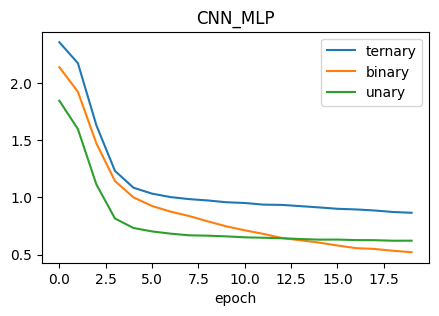

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3), dpi=100)
plt.plot(vloss_ternary)
plt.plot(vloss_binary)
plt.plot(vloss_unary)
plt.legend(['ternary', 'binary', 'unary'])
plt.title(args.model)
plt.xlabel('epoch')
plt.savefig('loss_{}.png'.format(args.model))
plt.show()

### References
* https://github.com/kimhc6028/relational-networks/